In [144]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold   
import cv2

In [145]:
def desSIFT(image):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image,None)
    return keypoints, descriptors

def describeORB(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image,None)
    return keypoints, descriptors

def describeSURF(image):
    surf = cv2.xfeatures2d.SURF_create()
    # it is better to have this value between 300 and 500
    surf.setHessianThreshold(400)
    keypoints, descriptors = surf.detectAndCompute(image,None)
    return keypoints, descriptors

In [146]:
def read_images(path, folders):
    images = []
    labels = []
    idx = 0
    for folder in folders:
        for filename in os.listdir(path+folder):
            image = cv2.imread(os.path.join(path+folder, filename))
            if image is not None:
                images.append(image)
                labels.append(idx)
                
        idx += 1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [147]:
def getDescriptors(images) : 
    descriptors = []
    
    for image in images : 
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
        keypoint, descriptor = describeSURF(gray_image)
        if descriptor is not None : 
            descriptors.extend(descriptor)
            
    descriptors = np.asarray(descriptors)    
    return descriptors

In [148]:
def getVLADDescriptors(images, image_labels, visualDic):
    descriptors = []
    labels = []
    
    idx = 0
    for image in images : 
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = cv2.resize(image, (150, 150), interpolation=cv2.INTER_AREA)
        keypoint, descriptor = describeSURF(gray_image)
        if descriptor is not None : 
            v = VLAD(descriptor, visualDic)
            descriptors.append(v)
            labels.append([image_labels[idx]])
        idx += 1
            
    descriptors = np.asarray(descriptors)
    labels = np.array(labels).astype(np.float32)
        
    return descriptors, labels

In [149]:
def VLAD(X, visualDictionary) : 
    
    predictedLabels = visualDictionary.predict(X)
    centers = visualDictionary.cluster_centers_
    labels = visualDictionary.labels_
    k = visualDictionary.n_clusters
    
    m,d = X.shape
    V=np.zeros([k,d])
    #computing the differences

    # for all the clusters (visual words)
    for i in range(k):
        # if there is at least one descriptor in that cluster
        if np.sum(predictedLabels==i)>0:
            # add the diferences
            V[i]=np.sum(X[predictedLabels==i,:]-centers[i],axis=0)
    

    V = V.flatten()
    # power normalization, also called square-rooting normalization
    V = np.sign(V)*np.sqrt(np.abs(V))

    # L2 normalization

    V = V/np.sqrt(np.dot(V,V))
    return V


In [150]:
# images, labels = read_images("../../../Assignment2/Panorama-BOVW/SIFT-SURF/",["Bikes", "Horses"])
images, labels = read_images("../../../Assignment2/Panorama-BOVW/SIFT-SURF/cifar-10/",["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

In [151]:
sift_des = getDescriptors(images)

In [152]:
visDic = MiniBatchKMeans(init='k-means++', n_clusters=8,max_iter=1000, batch_size=1000, n_init=10, max_no_improvement=10, verbose=0).fit(sift_des)

In [153]:
X = images
y = labels
print(labels)
cv = StratifiedKFold(n_splits=6, random_state=42)

scores = []
count = 0
for train_ind, validate_ind in cv.split(X, y):
    print("CV # - ", count)
    count += 1
    train_X, train_y = X[train_ind], y[train_ind]
    validate_X, validate_y = X[validate_ind], y[validate_ind]
    
    vlad_des, vlad_labels = getVLADDescriptors(train_X, train_y, visDic)
    print ("Hola")

    vlad_des_test, vlad_labels_test = getVLADDescriptors(validate_X, validate_y, visDic)
    clf = cv2.ml.KNearest_create()
    clf.train(np.float32(vlad_des), cv2.ml.ROW_SAMPLE, vlad_labels)
    ret, results, neighbours, dist = clf.findNearest(np.float32(vlad_des_test), k=240)
    score = accuracy_score(results, vlad_labels_test)
    scores.append(score)


[0 0 0 ... 9 9 9]
CV # -  0
Hola
CV # -  1
Hola
CV # -  2
Hola
CV # -  3
Hola
CV # -  4
Hola
CV # -  5
Hola


In [154]:
final_score = sum(scores)/len(scores)
print(final_score)

0.31935


In [155]:
print(scores)

[0.3194, 0.3185, 0.3177, 0.3207, 0.3197, 0.3201]


In [156]:
"""
SIFT
CV scores for k = 8:
[0.3082, 0.31299389816945083, 0.31373137313731375, 0.3086926077823347, 0.31273127312731275, 0.3111622324464893]
Average: 0.31125189744381687
CV scores for k = 10:
[0.3064, 0.30359107732319696, 0.3084308430843084, 0.3170951285385616, 0.30243024302430244, 0.3078615723144629]
Average: 0.30763481071413873
CV scores for k = 15:
[0.2981, 0.30069020706211863, 0.30813081308130813, 0.30419125737721314, 0.30823082308230826, 0.30406081216243247]
Average: 0.30390065212756345
CV scores for k = 50:
[0.286, 0.2882864859457837, 0.29222922292229225, 0.29268780634190256, 0.29322932293229326, 0.2996599319863973]
Average: 0.2920154616881115
"""

'\nSIFT\nCV scores for k = 8:\n[0.3082, 0.31299389816945083, 0.31373137313731375, 0.3086926077823347, 0.31273127312731275, 0.3111622324464893]\nAverage: 0.31125189744381687\nCV scores for k = 10:\n[0.3064, 0.30359107732319696, 0.3084308430843084, 0.3170951285385616, 0.30243024302430244, 0.3078615723144629]\nAverage: 0.30763481071413873\nCV scores for k = 15:\n[0.2981, 0.30069020706211863, 0.30813081308130813, 0.30419125737721314, 0.30823082308230826, 0.30406081216243247]\nAverage: 0.30390065212756345\nCV scores for k = 50:\n[0.286, 0.2882864859457837, 0.29222922292229225, 0.29268780634190256, 0.29322932293229326, 0.2996599319863973]\nAverage: 0.2920154616881115\n'

In [157]:
"""
SURF
CV scores for k = 8:
[0.3008, 0.3071, 0.2954, 0.3115, 0.3092, 0.3091]
Average: 0.3055166666666666
CV scores for k = 10:
[0.3034, 0.3088, 0.3095, 0.3082, 0.3086, 0.3087]
Average: 0.3078666666666667
CV scores for k = 15:
[0.3058, 0.309, 0.3135, 0.3115, 0.3049, 0.3118]
Average: 0.3094166666666667
CV scores for k = 50:
[0.3062, 0.2961, 0.2999, 0.3065, 0.3055, 0.3028]
Average: 0.30283333333333334
"""

'\nSURF\nCV scores for k = 8:\n[0.3008, 0.3071, 0.2954, 0.3115, 0.3092, 0.3091]\nAverage: 0.3055166666666666\nCV scores for k = 10:\n[0.3034, 0.3088, 0.3095, 0.3082, 0.3086, 0.3087]\nAverage: 0.3078666666666667\nCV scores for k = 15:\n[0.3058, 0.309, 0.3135, 0.3115, 0.3049, 0.3118]\nAverage: 0.3094166666666667\nCV scores for k = 50:\n[0.3062, 0.2961, 0.2999, 0.3065, 0.3055, 0.3028]\nAverage: 0.30283333333333334\n'

In [158]:
"""
SURF knn = 200:
k = 10:
0.3234666666666666
[0.3179, 0.3242, 0.3214, 0.3269, 0.3236, 0.3268]
SURF knn = 240:
k = 8:
0.31935
[0.3194, 0.3185, 0.3177, 0.3207, 0.3197, 0.3201]
k = 10:
0.3251
[0.3172, 0.3274, 0.3225, 0.329, 0.3229, 0.3316]
k = 15:
0.32504999999999995
[0.3189, 0.3268, 0.3231, 0.3293, 0.3212, 0.331]
"""

'\nSURF knn = 200:\nk = 10:\n0.3234666666666666\n[0.3179, 0.3242, 0.3214, 0.3269, 0.3236, 0.3268]\nSURF knn = 240:\nk = 10:\n0.3251\n[0.3172, 0.3274, 0.3225, 0.329, 0.3229, 0.3316]\nk = 15:\n0.32504999999999995\n[0.3189, 0.3268, 0.3231, 0.3293, 0.3212, 0.331]\n'

In [1]:
accuracies = [0.30786,0.3283,0.3308,0.332,0.3306,0.3294,0.32346,0.31935]
neighbors = [10,35,50,75,100,150,200,240]

In [5]:
import matplotlib.pyplot as plt

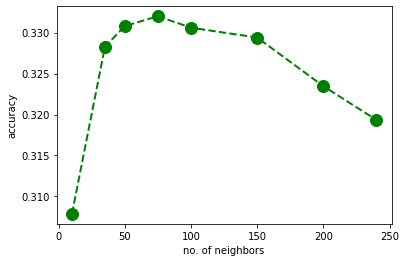

In [9]:
plt.xlabel("no. of neighbors")
plt.ylabel("accuracy")
plt.plot(neighbors, accuracies, 'go--', linewidth=2, markersize=12)